In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from skimage.io import imread
from skimage.transform import resize

import tifffile

In [2]:
images_directory = '/kaggle/input/satellite-cellua/data/images'
labels_directory = '/kaggle/input/satellite-cellua/data/labels'

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 12

In [4]:
def load_images(image_dir, mask_dir, img_height, img_width):
    image_paths = glob(os.path.join(images_directory, "*.tif"))
    mask_paths = glob(os.path.join(labels_directory, "*.png"))
    
    images = []
    masks = []
    
    for img_path, mask_path in zip(image_paths, mask_paths):
        img = imread(img_path)
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        images.append(img)
        
        mask = imread(mask_path, as_gray=True)
        mask = resize(mask, (img_height, img_width), mode='constant', preserve_range=True)
        masks.append(mask)
    
    images = np.array(images) / 255.0  # Normalize images
    masks = np.expand_dims(np.array(masks), axis=-1)  # Add channel dimension
    masks = (masks > 0).astype(np.float32)  # Binary mask
    
    return images, masks


X, y = load_images(images_directory, labels_directory, IMG_HEIGHT, IMG_WIDTH)

In [14]:
def show_prediction(image, ground_truth, predicted_mask):
    plt.figure(figsize=(18, 6))

    # Display the first channel of the original image as grayscale
    plt.subplot(1, 3, 1)
    plt.imshow(image[..., 0], cmap='gray')  # Display the first channel
    plt.title('Original Image (Channel 1)')
    
    # Display the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth.squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')
    
    # Display the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    
    plt.show()


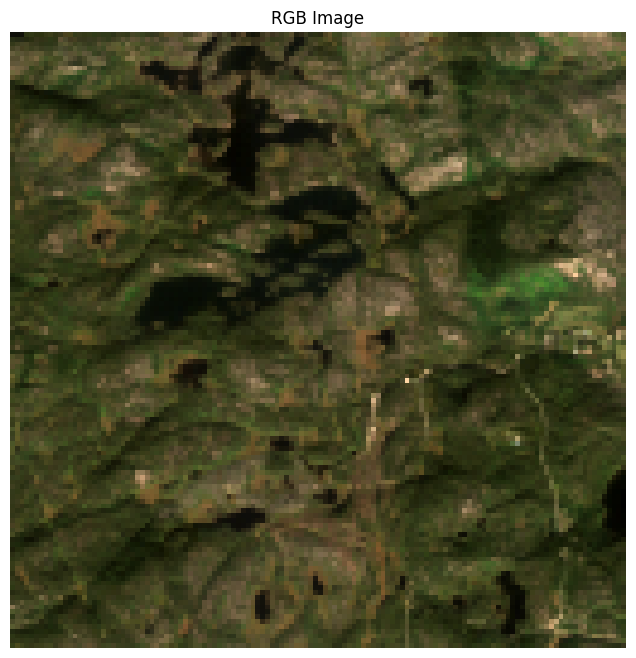

In [7]:
file_path = images_directory + '/0.tif'
img = tifffile.imread(file_path)

rgb_image = np.stack([img[..., 3], img[..., 2], img[..., 1]], axis=-1)

rgb_image_normalized = rgb_image / np.max(rgb_image)

plt.figure(figsize=(8, 8))
plt.imshow(rgb_image_normalized)
plt.title('RGB Image')
plt.axis('off')
plt.show()


In [34]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Conv2D(512, (2, 2), activation='relu', padding='same')(u6)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Conv2D(256, (2, 2), activation='relu', padding='same')(u7)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Conv2D(128, (2, 2), activation='relu', padding='same')(u8)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Conv2D(64, (2, 2), activation='relu', padding='same')(u9)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

    return model

# model.summary()


In [9]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [24]:
def iou_loss(y_true, y_pred, smooth=1e-6):
    """
    Compute the Intersection over Union (IoU) loss.
    
    Parameters:
        y_true (tf.Tensor): Ground truth mask.
        y_pred (tf.Tensor): Predicted mask.
        smooth (float): Smoothing factor to avoid division by zero.
        
    Returns:
        tf.Tensor: IoU loss.
    """
    # Flatten tensors
    y_true = tf.reshape(y_true, (-1,))
    y_pred = tf.reshape(y_pred, (-1,))

    # Compute intersection and union
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    # Compute IoU
    iou = (intersection + smooth) / (union + smooth)

    # IoU loss is 1 - IoU
    return 1.0 - iou


def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator


In [35]:
with strategy.scope():
    model = unet_model()

In [36]:
datagen = ImageDataGenerator()

history = model.fit(datagen.flow(X, y, batch_size=16), epochs=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 182ms/step - accuracy: 0.5963 - loss: 0.9495


In [43]:
img = X[0] 

img = np.expand_dims(img, axis=0)  

prediction = model.predict(img)
predicted_mask = (prediction > 0.5).astype(np.uint8)  # Threshold at 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


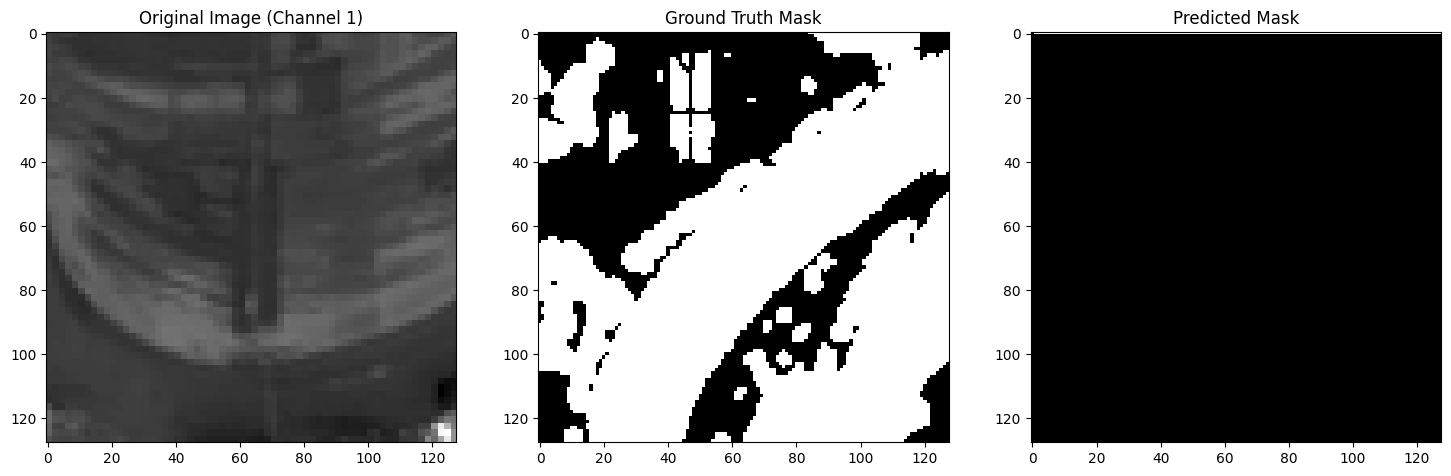

In [44]:
# Call the function with the image, ground truth mask, and predicted mask
show_prediction(img.squeeze(), y[0], predicted_mask.squeeze())

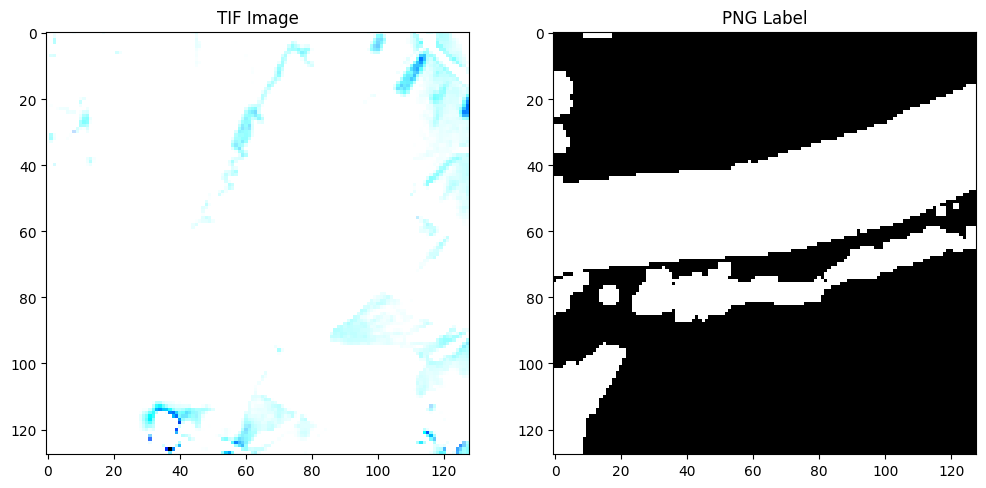

In [33]:
def show_sample(images, masks, index):
    plt.figure(figsize=(12, 6))
    
    # Display TIF image
    plt.subplot(1, 2, 1)
    img = images[index]
    
    # Ensure the image has 3 channels for RGB
    if img.shape[-1] != 3:
        img = img[..., :3]  # Use the first 3 channels if there are more
    plt.imshow(img)
    plt.title('TIF Image')
    
    # Display corresponding PNG mask
    plt.subplot(1, 2, 2)
    mask = masks[index].squeeze()
    plt.imshow(mask, cmap='gray')
    plt.title('PNG Label')
    
    plt.show()

# Show a sample from the dataset
show_sample(X, y, index=7)  # Change the index to see different samples